<a href="https://colab.research.google.com/github/AbedurRahman/Mosquito_images_classification/blob/main/Final_Thesis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import random
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
root_path = '/content/drive/MyDrive/Final Mosquito DataSet'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '../content/drive/MyDrive/Final Mosquito DataSet/TRAIN' 
seg_test_folders = '../content/drive/MyDrive/Final Mosquito DataSet/TEST'
seg_pred_folders = '../content/drive/MyDrive/Final Mosquito DataSet/PRED2'

In [7]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [8]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                   shear_range=0.2,
                                   zoom_range=0.2)


train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(512,512))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) 

validation_generator = validation_datagen.flow_from_directory(seg_test_folders, 
                                                              shuffle=True,
                                                              batch_size=1, 
                                                              class_mode='categorical', 
                                                              target_size=(512,512))

Found 2727 images belonging to 6 classes.
Found 739 images belonging to 6 classes.


In [9]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'Aedes Albopictus': 0, 'Aedes vexans': 1, 'Anopheles sinensis': 2, 'Culex pipiens': 3, 'Culex tritaeniorhynchus': 4, 'Non vectors': 5}
{0: 'Aedes Albopictus', 1: 'Aedes vexans', 2: 'Anopheles sinensis', 3: 'Culex pipiens', 4: 'Culex tritaeniorhynchus', 5: 'Non vectors'}


In [10]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

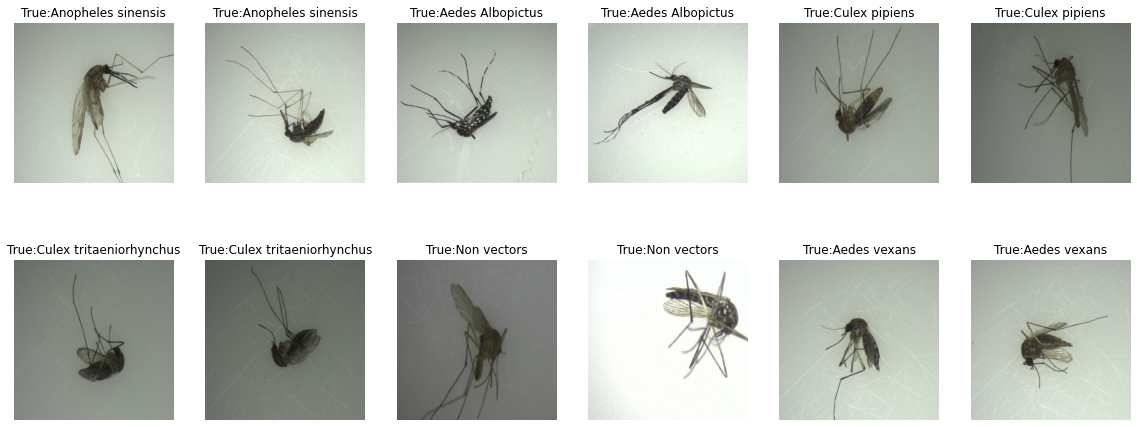

In [11]:
show_few_images(2)

In [12]:
tf.keras.backend.clear_session()

In [13]:
from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

# **VGG16**

In [14]:
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from glob import glob

In [15]:
vgg16_model = VGG16(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_tensor=Input(shape=(512,512,3)))

for layers in vgg16_model.layers:
            layers.trainable=False

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(256, activation = 'relu')(vgg_x)
vgg_x = Dense(6, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)

58900480/58889256 [==============================] - 0s 0us/step


In [16]:
vgg16_final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [17]:
vgg16_final_model.compile(loss = 'categorical_crossentropy', 
                          optimizer= 'adam',
                          metrics=['acc'])

Epoch 1/40
43/43 [==============================] - ETA: 0s - loss: 1.7446 - acc: 0.2670 
Epoch 00001: val_acc improved from -inf to 0.41543, saving model to vgg_16_-saved-model-01-acc-0.42.hdf5
43/43 [==============================] - 977s 22s/step - loss: 1.7446 - acc: 0.2670 - val_loss: 1.6747 - val_acc: 0.4154
Epoch 2/40
43/43 [==============================] - ETA: 0s - loss: 1.5894 - acc: 0.4155
Epoch 00002: val_acc did not improve from 0.41543
43/43 [==============================] - 181s 4s/step - loss: 1.5894 - acc: 0.4155 - val_loss: 1.5323 - val_acc: 0.4154
Epoch 3/40
43/43 [==============================] - ETA: 0s - loss: 1.4477 - acc: 0.5079
Epoch 00003: val_acc improved from 0.41543 to 0.50203, saving model to vgg_16_-saved-model-03-acc-0.50.hdf5
43/43 [==============================] - 184s 4s/step - loss: 1.4477 - acc: 0.5079 - val_loss: 1.4020 - val_acc: 0.5020
Epoch 4/40
43/43 [==============================] - ETA: 0s - loss: 1.3238 - acc: 0.5578
Epoch 00004: val_ac

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


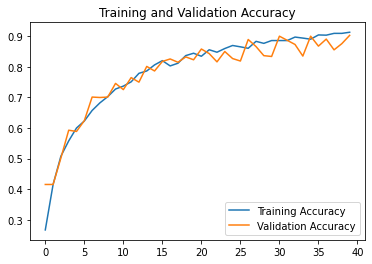

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


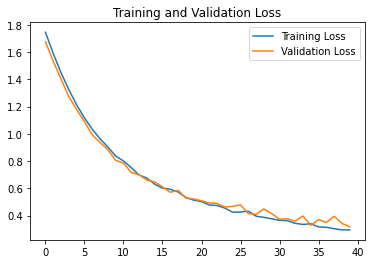

<Figure size 432x288 with 0 Axes>

In [18]:
# VGG16
number_of_epochs = 40
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', 
                                                    verbose=1, 
                                                    save_best_only=True,
                                                    mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=5)

vgg16_history = vgg16_final_model.fit(train_generator, 
                                      epochs = number_of_epochs ,
                                      validation_data = validation_generator,
                                      callbacks=[vgg_checkpoint,vgg_early_stopping],
                                      verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

# **VGG19**

In [ ]:
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
vgg19_model = VGG19(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_tensor=Input(shape=(224,224, 3)))

for layers in vgg19_model.layers:
            layers.trainable=False

last_output = vgg19_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(256, activation = 'relu')(vgg_x)
vgg_x = Dense(6, activation = 'softmax')(vgg_x)
vgg19_final_model = Model(vgg19_model.input, vgg_x)

80150528/80134624 [==============================] - 3s 0us/step


In [ ]:
vgg19_final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg19_final_model.compile(loss = 'categorical_crossentropy', 
                          optimizer= 'adam',
                          metrics=['acc'])

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 1.7105 - acc: 0.2851
Epoch 00001: val_acc improved from -inf to 0.35995, saving model to vgg_19_-saved-model-01-acc-0.36.hdf5
45/45 [==============================] - 93s 2s/step - loss: 1.7105 - acc: 0.2851 - val_loss: 1.5927 - val_acc: 0.3599
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 1.5048 - acc: 0.4426
Epoch 00002: val_acc improved from 0.35995 to 0.41137, saving model to vgg_19_-saved-model-02-acc-0.41.hdf5
45/45 [==============================] - 90s 2s/step - loss: 1.5048 - acc: 0.4426 - val_loss: 1.4390 - val_acc: 0.4114
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 1.3614 - acc: 0.5099
Epoch 00003: val_acc improved from 0.41137 to 0.48850, saving model to vgg_19_-saved-model-03-acc-0.49.hdf5
45/45 [==============================] - 90s 2s/step - loss: 1.3614 - acc: 0.5099 - val_loss: 1.3170 - val_acc: 0.4885
Epoch 4/50
45/45 [==============================] - ETA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


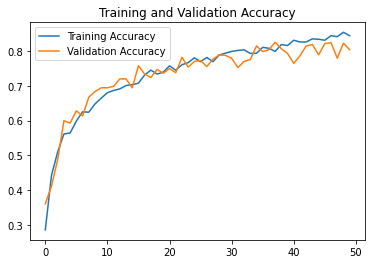

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


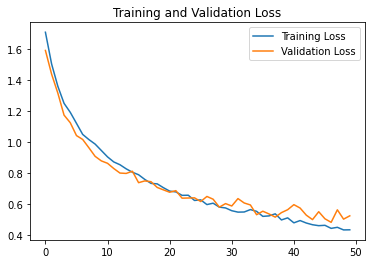

<Figure size 432x288 with 0 Axes>

In [ ]:
# VGG19
number_of_epochs = 50
vgg19_filepath = 'vgg_19_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg19_filepath, monitor='val_acc', 
                                                    verbose=1, 
                                                    save_best_only=True,
                                                    mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=5)

vgg19_history = vgg19_final_model.fit(train_generator, 
                                      epochs = number_of_epochs ,
                                      validation_data = validation_generator,
                                      callbacks=[vgg_checkpoint,vgg_early_stopping],
                                      verbose=1)

do_history_stuff(vgg19_history, 'vgg19_model')

# **Xception**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline

In [ ]:
xception_model=tf.keras.applications.xception.Xception(
              include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224,224, 3)),
    pooling='avg',
    classes=6,
)

83697664/83683744 [==============================] - 3s 0us/step


In [ ]:

for layers in xception_model.layers:
            layers.trainable=False

last_output = xception_model.layers[-1].output
xception_x = Flatten()(last_output)
xception_x = Dense(256, activation = 'relu')(xception_x)
xception_x = Dense(6, activation = 'softmax')(xception_x)
xception_model_final_model = Model(xception_model.input, xception_x)

In [ ]:
xception_model_final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
xception_model_final_model.compile(loss = 'categorical_crossentropy',
                               optimizer= 'adam',
                               metrics=['acc'])

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 0.2638 - acc: 0.9136
Epoch 00001: val_acc improved from -inf to 0.82815, saving model to xception_-saved-model-01-acc-0.83.hdf5
45/45 [==============================] - 84s 2s/step - loss: 0.2638 - acc: 0.9136 - val_loss: 0.4716 - val_acc: 0.8281
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 0.2768 - acc: 0.8994
Epoch 00002: val_acc improved from 0.82815 to 0.83762, saving model to xception_-saved-model-02-acc-0.84.hdf5
45/45 [==============================] - 83s 2s/step - loss: 0.2768 - acc: 0.8994 - val_loss: 0.4126 - val_acc: 0.8376
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.2732 - acc: 0.9101
Epoch 00003: val_acc did not improve from 0.83762
45/45 [==============================] - 83s 2s/step - loss: 0.2732 - acc: 0.9101 - val_loss: 0.4520 - val_acc: 0.8227
Epoch 4/10
45/45 [==============================] - ETA: 0s - loss: 0.2744 - acc: 0.9030
Epoch 00004: val_acc

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


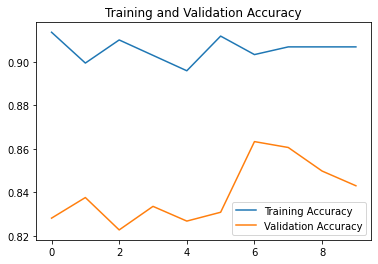

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


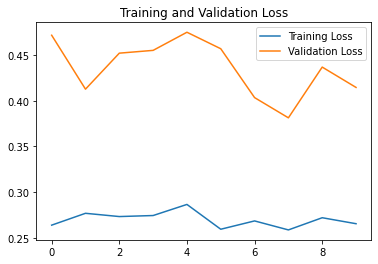

<Figure size 432x288 with 0 Axes>

In [ ]:
number_of_epochs = 10
xception_filepath = 'xception_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
xception_checkpoint = tf.keras.callbacks.ModelCheckpoint(xception_filepath, monitor='val_acc', 
                                                    verbose=1, 
                                                    save_best_only=True,
                                                    mode='max')
xception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=5)

xception_history = vgg16_final_model.fit(train_generator, 
                                      epochs = number_of_epochs ,
                                      validation_data = validation_generator,
                                      callbacks=[xception_checkpoint,xception_early_stopping],
                                      verbose=1)

do_history_stuff(xception_history, 'xception_model')

# **ResNet50**

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', 
                          include_top=False,
                          input_tensor=Input(shape=(224,224,3)), 
                          pooling='avg',
                          classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(512,activation='relu')(resnet50_x)
resnet50_x = Dense(6,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)

In [ ]:
resnet50_x_final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
resnet50_x_final_model.compile(loss = 'categorical_crossentropy',
                               optimizer= 'adam',
                               metrics=['acc'])

In [ ]:
number_of_epochs = 10
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath,
                                                       monitor='val_acc', 
                                                       verbose=1, 
                                                       save_best_only=True,
                                                       mode='max')

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                         patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.05,
                              patience=5,
                              min_lr=0.000002)

callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]


resnet50_history = resnet50_x_final_model.fit( train_generator,
                                              epochs = number_of_epochs ,
                                              validation_data = validation_generator,
                                              callbacks=callbacklist,
                                              verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')

# **InceptionV3**

In [19]:
InceptionV3_model = InceptionV3(input_shape=(512,512,3),
                                weights='imagenet',
                                include_top=False)

for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [20]:
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(256, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)

In [21]:

InceptionV3_x_final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [22]:
InceptionV3_x_final_model.compile(optimizer='adam', 
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

Epoch 1/5
43/43 [==============================] - 193s 4s/step - loss: 15.3115 - accuracy: 0.5695 - val_loss: 52.4688 - val_accuracy: 0.2490
Epoch 2/5
43/43 [==============================] - 177s 4s/step - loss: 0.2119 - accuracy: 0.9270 - val_loss: 3.6658 - val_accuracy: 0.5332
Epoch 3/5
43/43 [==============================] - 178s 4s/step - loss: 0.0433 - accuracy: 0.9864 - val_loss: 0.1357 - val_accuracy: 0.9621
Epoch 4/5
43/43 [==============================] - 176s 4s/step - loss: 0.0224 - accuracy: 0.9945 - val_loss: 0.1301 - val_accuracy: 0.9513
Epoch 5/5
43/43 [==============================] - 176s 4s/step - loss: 0.0176 - accuracy: 0.9945 - val_loss: 0.0125 - val_accuracy: 0.9959


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


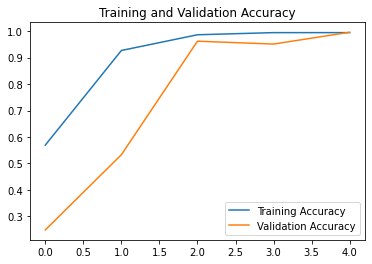

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


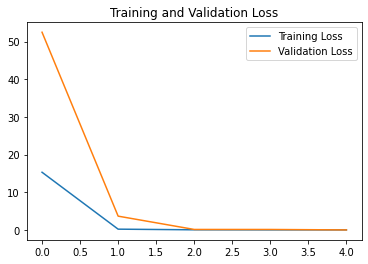

<Figure size 432x288 with 0 Axes>

In [23]:
number_of_epochs =5
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'

inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, 
                                                          monitor='acc',
                                                          verbose=1, 
                                                          save_best_only=True,
                                                          mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, 
                                                    epochs = number_of_epochs,
                                                    validation_data = validation_generator,
                                                    callbacks=[inception_checkpoint,inception_early_stopping],
                                                    verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)

# **MobileNet**

In [24]:
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from glob import glob

In [25]:
mobilenet_model = MobileNetV2(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_tensor=Input(shape=(512,512, 3)))

for layers in mobilenet_model.layers:
            layers.trainable=False

last_output = mobilenet_model.layers[-1].output
mobile_x = Flatten()(last_output)
mobile_x = Dense(256, activation = 'relu')(mobile_x)
mobile_x = Dense(6, activation = 'softmax')(mobile_x)
mobilenet_final_model = Model(mobilenet_model.input, mobile_x)

9420800/9406464 [==============================] - 0s 0us/step


In [26]:
mobilenet_final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [27]:
mobilenet_final_model.compile(loss = 'categorical_crossentropy', 
                          optimizer= 'adam',
                          metrics=['acc'])

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 0.8219 - acc: 0.7242
Epoch 00001: val_acc improved from -inf to 0.89039, saving model to mobile_v2_-saved-model-01-acc-0.89.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


43/43 [==============================] - 164s 4s/step - loss: 0.8219 - acc: 0.7242 - val_loss: 0.4002 - val_acc: 0.8904
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 0.2871 - acc: 0.9259
Epoch 00002: val_acc improved from 0.89039 to 0.96346, saving model to mobile_v2_-saved-model-02-acc-0.96.hdf5
43/43 [==============================] - 159s 4s/step - loss: 0.2871 - acc: 0.9259 - val_loss: 0.1991 - val_acc: 0.9635
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 0.1689 - acc: 0.9644
Epoch 00003: val_acc improved from 0.96346 to 0.97158, saving model to mobile_v2_-saved-model-03-acc-0.97.hdf5
43/43 [==============================] - 160s 4s/step - loss: 0.1689 - acc: 0.9644 - val_loss: 0.1463 - val_acc: 0.9716
Epoch 4/10
43/43 [==============================] - ETA: 0s - loss: 0.1462 - acc: 0.9622
Epoch 00004: val_acc did not improve from 0.97158
43/43 [==============================] - 159s 4s/step - loss: 0.1462 - acc: 0.9622 - val_loss: 0.1354

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


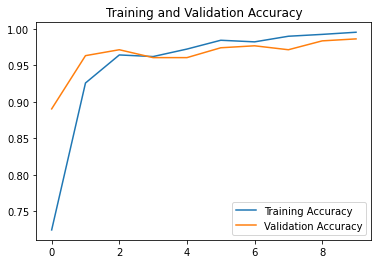

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


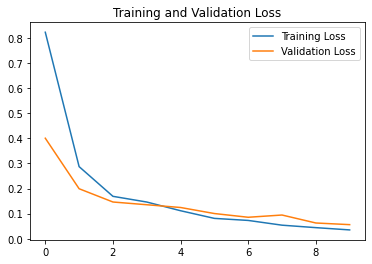

<Figure size 432x288 with 0 Axes>

In [28]:
number_of_epochs = 10
mobile_filepath = 'mobile_v2_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
mobile_checkpoint = tf.keras.callbacks.ModelCheckpoint(mobile_filepath, monitor='val_acc', 
                                                    verbose=1, 
                                                    save_best_only=True,
                                                    mode='max')
mobile_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                      patience=5)

mobile_history = mobilenet_final_model.fit(train_generator, 
                                      epochs = number_of_epochs ,
                                      validation_data = validation_generator,
                                      callbacks=[mobile_checkpoint,mobile_early_stopping],
                                      verbose=1)

do_history_stuff(mobile_history, 'mobilenet_model')

## **Combining the best models of VGG16, InceptionV3 & MobileNetV2**

In [34]:
vgg_best_model = vgg16_final_model
inception_best_model = InceptionV3_x_final_model
mobile_best_model = mobilenet_final_model

In [35]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
#vgg19_pred = []
inception_pred = []
#xception_pred = []
mobile_pred = []

for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(512,512))
        img_normalized = img/255

        #vgg16
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #vgg19
        #vgg19_image_prediction = np.argmax(vgg19_best_model.predict(np.array([img_normalized])))
        #vgg19_pred.append(vgg19_image_prediction)
        

        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        #Xception
        #xception_image_prediction = np.argmax(xception_best_model.predict(np.array([img_normalized])))
        #xception_pred.append(xception_image_prediction) 

        #mobile
        mobile_image_prediction = np.argmax(mobile_best_model.predict(np.array([img_normalized])))
        mobile_pred.append(mobile_image_prediction)
        
        
       
        
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, inception_image_prediction,mobile_image_prediction])                                  
        combined_model_pred.append(image_prediction)

In [36]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

# **Performance**

**combined vote**

Model Accuracy 0.9756427604871448
                         precision    recall  f1-score   support

       Aedes Albopictus       0.98      1.00      0.99       120
           Aedes vexans       0.98      0.96      0.97       118
     Anopheles sinensis       0.94      0.98      0.96       121
          Culex pipiens       0.98      0.96      0.97       129
Culex tritaeniorhynchus       0.98      0.99      0.99       120
            Non vectors       0.99      0.96      0.98       131

               accuracy                           0.98       739
              macro avg       0.98      0.98      0.98       739
           weighted avg       0.98      0.98      0.98       739



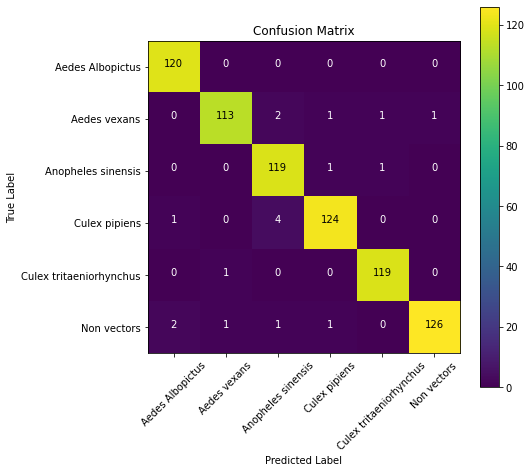

In [37]:
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

**VGG16**

Model Accuracy 0.7956698240866035
                         precision    recall  f1-score   support

       Aedes Albopictus       0.91      1.00      0.95       120
           Aedes vexans       0.63      0.83      0.72       118
     Anopheles sinensis       0.66      0.94      0.78       121
          Culex pipiens       0.86      0.79      0.82       129
Culex tritaeniorhynchus       0.94      0.70      0.80       120
            Non vectors       0.99      0.53      0.69       131

               accuracy                           0.80       739
              macro avg       0.83      0.80      0.79       739
           weighted avg       0.83      0.80      0.79       739



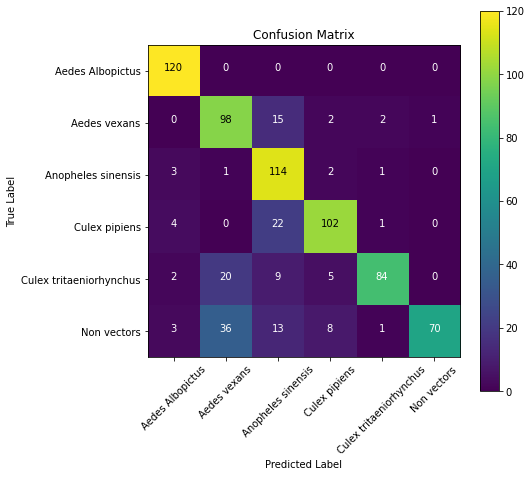

In [38]:
# VGG model classification report
clf_report(true_value, vgg_pred)

**MobileNet**

Model Accuracy 0.9769959404600812
                         precision    recall  f1-score   support

       Aedes Albopictus       0.96      1.00      0.98       120
           Aedes vexans       0.99      0.96      0.97       118
     Anopheles sinensis       1.00      0.96      0.98       121
          Culex pipiens       0.95      0.98      0.97       129
Culex tritaeniorhynchus       0.97      0.98      0.98       120
            Non vectors       0.99      0.98      0.98       131

               accuracy                           0.98       739
              macro avg       0.98      0.98      0.98       739
           weighted avg       0.98      0.98      0.98       739



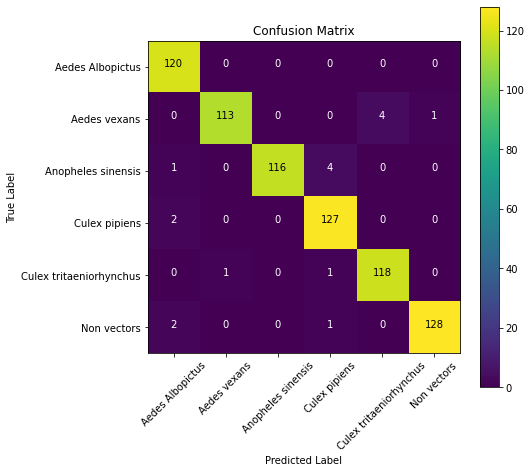

In [39]:
#MobileNet model classification report
clf_report(true_value, mobile_pred)

**InceptionV3**

Model Accuracy 0.9404600811907984
                         precision    recall  f1-score   support

       Aedes Albopictus       0.74      1.00      0.85       120
           Aedes vexans       1.00      0.86      0.93       118
     Anopheles sinensis       1.00      0.94      0.97       121
          Culex pipiens       0.99      0.86      0.92       129
Culex tritaeniorhynchus       1.00      1.00      1.00       120
            Non vectors       1.00      0.98      0.99       131

               accuracy                           0.94       739
              macro avg       0.95      0.94      0.94       739
           weighted avg       0.96      0.94      0.94       739



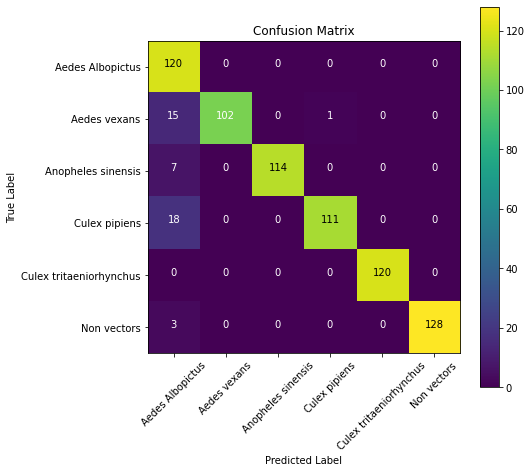

In [40]:
# Inception model classification report
clf_report(true_value, inception_pred)

# **Predection**

InceptionV3

In [249]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [250]:
CATEGORIES = ["Aedes Albopictus","Aedes vexans","Anopheles sinensis","Culex pipiens","Culex tritaeniorhynchus","Non vectors"]

In [248]:
img=image.load_img(r"/content/drive/MyDrive/Final Mosquito DataSet/PRED/Aedes_Albo0380.JPG",target_size=(512,512))

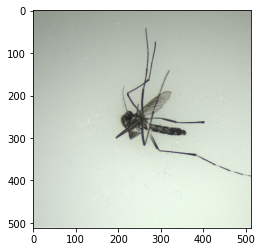

In [251]:
plt.imshow(img)

In [252]:
img1=image.img_to_array(img)


In [253]:
img1.shape

(512, 512, 3)

In [254]:
img1=img1/255


In [255]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [256]:
import numpy as np
img1=np.expand_dims(img1,axis=0)
img_data=preprocess_input(img1)
img_data.shape

(1, 512, 512, 3)

In [257]:
InceptionV3_x_final_model.predict(img_data)

array([[4.8202634e-01, 1.0841978e-03, 2.3843324e-01, 5.0736483e-02,
        1.1953629e-05, 2.2770780e-01]], dtype=float32)

In [258]:
predictions=InceptionV3_x_final_model.predict(img_data)

In [259]:
predictions[0][0]

0.48202634

In [260]:
predictions[0][1]

0.0010841978

In [261]:
predictions[0][2]

0.23843324

In [262]:
predictions[0][3]

0.050736483

In [263]:
predictions[0][4]

1.1953629e-05

In [264]:
predictions[0][5]

0.2277078

In [266]:
rslt= predictions

mx = 0
name = 0
for i in range(0,6):
  if rslt[0][i] > mx :
    mx = rslt[0][i]
    name = i
print([CATEGORIES[name]])

['Aedes Albopictus']


**VGG16**

In [267]:
img=image.load_img(r"/content/drive/MyDrive/Final Mosquito DataSet/PRED/An_Sin0533.JPG",target_size=(512,512))

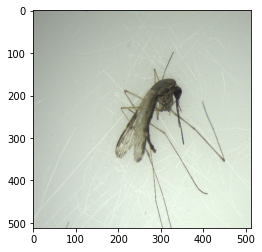

In [268]:
plt.imshow(img)

In [269]:
img1=image.img_to_array(img)

In [270]:
img1.shape

(512, 512, 3)

In [271]:
img1=img1/255

In [272]:
import numpy as np
img1=np.expand_dims(img1,axis=0)
img_data=preprocess_input(img1)
img_data.shape

(1, 512, 512, 3)

In [273]:
vgg16_final_model.predict(img_data)

array([[1.03284656e-04, 1.32013054e-03, 8.31503332e-01, 2.78492807e-04,
        1.22868940e-02, 1.54507831e-01]], dtype=float32)

In [274]:
predictions=vgg16_final_model.predict(img_data)

In [275]:
predictions[0][0]

0.000103284656

In [276]:
predictions[0][1]

0.0013201305

In [277]:
predictions[0][2]

0.83150333

In [278]:
predictions[0][3]

0.0002784928

In [279]:
predictions[0][4]

0.012286894

In [280]:
predictions[0][5]

0.15450783

In [281]:
rslt= predictions

mx = 0
name = 0
for i in range(0,6):
  if rslt[0][i] > mx :
    mx = rslt[0][i]
    name = i
print([CATEGORIES[name]])

['Anopheles sinensis']


**MobileNet**

In [282]:
img=image.load_img(r"/content/drive/MyDrive/Final Mosquito DataSet/PRED/non_vector0020.JPG",target_size=(512,512))

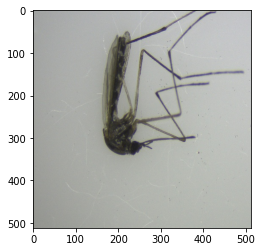

In [283]:
plt.imshow(img)

In [284]:
img1=image.img_to_array(img)

In [285]:
img1.shape

(512, 512, 3)

In [286]:
img1=img1/255

In [287]:
import numpy as np
img1=np.expand_dims(img1,axis=0)
img_data=preprocess_input(img1)
img_data.shape

(1, 512, 512, 3)

In [288]:
mobilenet_final_model(img_data)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[4.4041473e-09, 3.7841628e-09, 1.9142885e-02, 2.4815147e-10,
        6.0808838e-05, 9.8079634e-01]], dtype=float32)>

In [289]:
predictions=mobilenet_final_model(img_data)

In [290]:
predictions[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=4.4041473e-09>

In [291]:
predictions[0][1]

<tf.Tensor: shape=(), dtype=float32, numpy=3.7841628e-09>

In [292]:
predictions[0][2]

<tf.Tensor: shape=(), dtype=float32, numpy=0.019142885>

In [220]:
predictions[0][3]

<tf.Tensor: shape=(), dtype=float32, numpy=2.9964134e-10>

In [293]:
predictions[0][4]

<tf.Tensor: shape=(), dtype=float32, numpy=6.0808838e-05>

In [294]:
predictions[0][5]

<tf.Tensor: shape=(), dtype=float32, numpy=0.98079634>

In [295]:
rslt= predictions

mx = 0
name = 0
for i in range(0,6):
  if rslt[0][i] > mx :
    mx = rslt[0][i]
    name = i
print([CATEGORIES[name]])

['Non vectors']


### **Another predection**

In [296]:
img=image.load_img(r"/content/drive/MyDrive/Final Mosquito DataSet/PRED/100.JPG",target_size=(512,512))

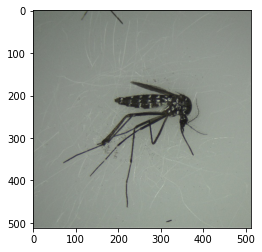

In [297]:
plt.imshow(img)

In [298]:
img1=image.img_to_array(img)

In [299]:
img1.shape

(512, 512, 3)

In [300]:
img1=img1/255

In [301]:
import numpy as np
img1=np.expand_dims(img1,axis=0)
img_data=preprocess_input(img1)
img_data.shape

(1, 512, 512, 3)

In [302]:
InceptionV3_x_final_model.predict(img_data)

array([[3.6712912e-01, 1.1879888e-03, 2.7435461e-01, 9.5689252e-02,
        2.9662482e-05, 2.6160941e-01]], dtype=float32)

In [303]:
predictions=InceptionV3_x_final_model.predict(img_data)

In [304]:
predictions[0][0]

0.36712912

In [305]:
predictions[0][1]

0.0011879888

In [306]:
predictions[0][2]

0.2743546

In [307]:
predictions[0][3]

0.09568925

In [308]:
predictions[0][4]

2.9662482e-05

In [309]:
predictions[0][5]

0.2616094

In [310]:
rslt= predictions

mx = 0
name = 0
for i in range(0,6):
  if rslt[0][i] > mx :
    mx = rslt[0][i]
    name = i
print([CATEGORIES[name]])

['Aedes Albopictus']
